
## What does this notebook do?

This notebook gets the Landsat 8 data that has 6 spectral bands including visible (red,green,blue) and invisible (nir, swir1, swir2) bands. These bands are plotted individually and combined. Also, the NDVI and NDWI are calculated and plotted from these bands.


**Note:** This example requires data for both True Color and False Color. We get these via two separate calls to the GSKY server.

**P.S**: This is using the dev GSKY server. Change it to production later.

###### Specifics

- Converting a DEA notebook example to use GSKY instaed of datacube.

- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example.

- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.

- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.

- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 23 October, 2019

In [8]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 22/10/2019; Last Modified: 23/10/2019  #
##########################################################

from owslib.wcs import WebCoverageService
from random import randrange
import os
import xarray as xr
%matplotlib inline

In [9]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'http://130.56.242.15/ows/ipynb'
wcs = WebCoverageService(gsky_url, version='1.0.0')
layer = "landsat8_nbar_16day"

# Uncomment below to see all layers.

#for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

In [10]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times-1
#print ("Total of", n_times,'timepositions:\n\n', time[m:n])

# Unlike in the case of datacube, where a time range can be specified, GSKY requires a specific date.
# This specific time slice is specified below. 
t = n-3
wcs[layer].timepositions[t]

'2013-06-07T00:00:00.000Z'

In [11]:
# Specify a 2D array of BBoxes as west, north, east, south in EPSG:4326 149.05, 149.17 -35.25, -35.35
w = 10;
BBoxes = [0 for x in range(w)] 
BBoxes[1] = ['148.62,-35.14,149.32,-36.58'] # Canberra 2013-04-04

# A valid BBox with data will be automatically chosen for that date.
bbox = BBoxes[1]
bbox

['148.62,-35.14,149.32,-36.58']

In [12]:
# If you know another BBox containing data (Tip: use TerriaMap to find out) then type it in below.
#bbox = ['130.00,-27.00,131.00,-29.00']

x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[0][14:20])
Y = float(bbox[0][21:27])
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 337)))
bbox = (x,y,X,Y)
bbox

(148.62, -35.14, 150.83, -36.58)

In [13]:
# Construct a WCS call to GSKY and send it.
output = wcs.getCoverage(identifier=layer, Styles='ftc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)
print(output.geturl())

http://130.56.242.15/ows/ipynb?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=148.62%2C-35.14%2C150.83%2C-36.58&time=2013-06-07T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=ftc


In [14]:
# Get the output data from GSKY and write it in a *.nc file
rand = str(randrange(1000))
ncfile = './output/gsky_wcs_' + rand + '.nc'
with open(ncfile, 'wb') as f:
    f.write(output.read())

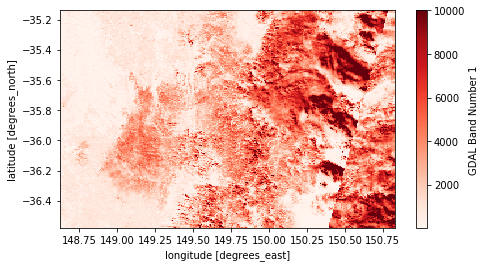

In [15]:
# Read the NetCDF file and convert it into an xarray dataset
ds = xr.open_dataset(ncfile)

# Delete the created NetCDF file
try:
    os.remove(ncfile)
except OSError:
    pass

# Plot the three bands in the dataset.
# Set all nodata pixels to `NaN`:
#ds = masking.mask_invalid_data(ds)

# Plot the red band
ds.Band1.plot(figsize=(7.51, 4.00), cmap = 'Reds');  
# This works too: 
#ds['Band1'].plot(figsize=(7.51, 4.00), cmap = 'Reds')

# Display the raw data
#ds


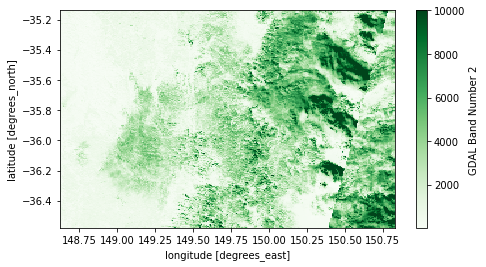

In [16]:
# Plot the green band
ds.Band2.plot(figsize=(7.51, 4.00), cmap = 'Greens');  

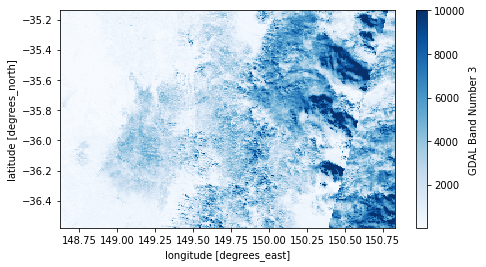

In [17]:
# Plot the blue band
ds.Band3.plot(figsize=(7.51, 4.00), cmap = 'Blues');  

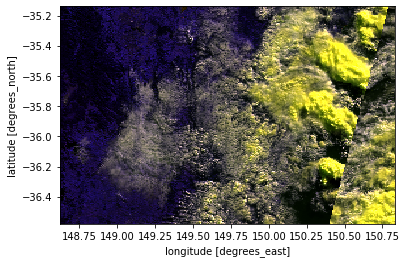

In [18]:
# Plot three bands together
ds[['Band1', 'Band3', 'Band5']].to_array().plot.imshow(robust=True)


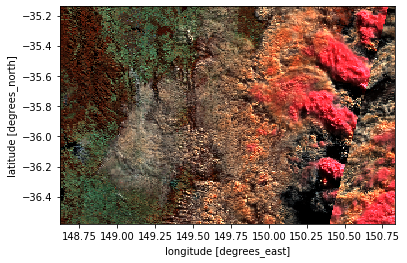

In [19]:
# Plot three bands (nir, swir1, swir2) together
ds[['Band4', 'Band5', 'Band6']].to_array().plot.imshow(robust=True)
#ds

In [20]:
# Compute NDWI using the formula (green - nir) / (green + nir). This will calculate 
# NDWI for every time-step in the dataset:
ds_ndwi = (ds.Band2 - ds.Band4) / (ds.Band2 + ds.Band4)
#ds_ndwi
wcs[layer].timepositions[t]

'2013-06-07T00:00:00.000Z'

In [24]:
# We can now add this back into our dataset as a new data variable:
ds["NDWI"] = ds_ndwi
ds["time"] = wcs[layer].timepositions[t]



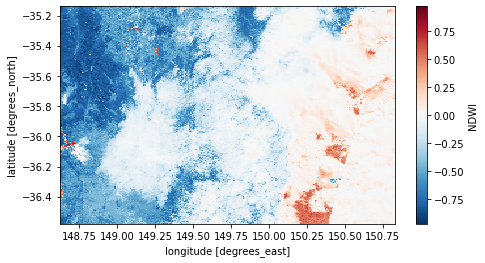

In [22]:
# First, we select the variable we want ('NDWI'), and then make a 
# plot with one column for each time-step:
ds.NDWI.plot(figsize=(7.51, 4.00),)


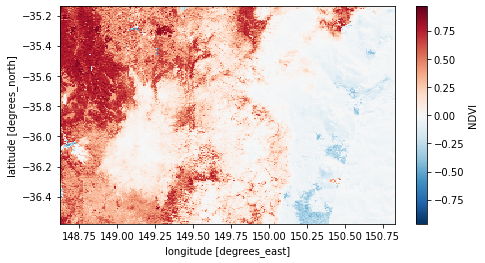

In [23]:
# Compute NDVI using the formula (nir - red) / (nir + red)
ds_ndvi = (ds.Band4 - ds.Band1) / (ds.Band4 + ds.Band1)

# Add this back into our dataset as a new data variable:
ds["NDVI"] = ds_ndvi

# Plot:
ds.NDVI.plot(figsize=(7.51, 4.00));

#### Acknowledgements

This notebook page is derived from this [DEA notebook](https://docs.dea.ga.gov.au/notebooks/05_Temporal_analysis/SnowMonitoringUsingLandsat.html) and extensively changed to use GSKY server. Some of the text used here are directly copied from the DEA page.